In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from inventoryManagement import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")
sns.set_context("talk")

In [11]:
def existingATReorderPolicy(inputs):
    if inputs[0] <= 0:
        return -1
    elif inputs[0] > 0 and inputs[0] <= 5:
        return np.floor(5.0/12*inputs[0])
    elif inputs[0] > 5 and inputs[0] < 50:
        return np.floor(5.0/12*inputs[0])
    else:
        return np.floor(inputs[0]/3.0)
        
def existingATMILPolicy(mu):
    if mu <= 0:
        return 0
    elif mu > 0 and mu <= 5:
        return np.ceil(mu)
    elif mu > 5 and mu < 50:
        return np.ceil(2.0/3*mu)
    else:
        return np.ceil(mu/2.0)
        
def proposedATReorderPolicy(inputs):
    if inputs[0] <= 0:
        return -1
    else:
        return np.floor( 1.4*inputs[0]*(inputs[1]+10)/365.0 )
        
def proposedATMILPolicy(mu):
    if mu <= 0:
        return 0
    elif mu > 0 and mu <= 5:
        return np.ceil(mu)
    elif mu > 5 and mu < 50:
        return np.ceil(2.0/3*mu)
    else:
        return np.ceil(mu/2.0)
    
def calculatePerformance(atData, reorderPolicy, milPolicy, milVariable):
    atData['Purchase Volume'] = atData['Total Usage']*atData['Unit Cost']
    atData['Daily Demand'] = atData['Total Usage']/365.0
    atData['theta'] = atData['Daily Demand'] * atData['Lead Time (days)']
    atData['r'] = [ reorderPolicy(inputs) for inputs in zip(atData['Total Usage'], atData['Lead Time (days)'] ) ]
    atData['mil'] = [ milPolicy(mu) for mu in atData[milVariable] ]
    atData['Q'] = atData['mil'] - atData['r']
    atData['Order Frequency'] = atData['Total Usage']/atData['Q']
    atData['Order Interval'] = 365.0/atData['Order Frequency']
    atData['Service Level'] = [min(GPoisson(r, theta), 0.9999) for r, theta in zip(atData['r'], atData['theta'])]
    atData['Fill Rate'] = [SPoisson(Q, r, theta) for Q, r, theta in zip(atData['Q'], atData['r'], atData['theta'])]
    atData['Backorder Level'] = [ BPoisson(Q, r, theta) for Q, r, theta in zip(atData['Q'], atData['r'], atData['theta']) ]
    atData['Inventory Level'] = [ IPoisson(Q, r, theta, b) for Q, r, theta, b in zip(atData['Q'], atData['r'], atData['theta'], atData['Backorder Level']) ]
    atData['I Investment'] = atData['Unit Cost']*atData['Inventory Level']
    atData['Implied A/i_h'] = [ Q**2*c/(2*D) if D >0.1 else 0 for Q, c, D in zip(atData['Q'], atData['Unit Cost'], atData['Total Usage']) ]
    atData['Implied C_s/i_h'] = atData['Unit Cost']*atData['Service Level']/(1-atData['Service Level'])

In [12]:
#Load A&T data
atRawData = pd.read_csv('dcData.csv', ',')

#Analyze current performance
atCurrent = atRawData.copy(deep=True)
atCurrent = atCurrent.loc[atCurrent['Total Usage'] > 0]
calculatePerformance(atCurrent, existingATReorderPolicy, existingATMILPolicy, 'Total Usage')

#Analyze proposed performance
atProposed = atRawData.copy(deep=True)
atProposed = atProposed.loc[atProposed['Total Usage'] > 0]
calculatePerformance(atProposed, proposedATReorderPolicy, proposedATMILPolicy, 'Total Usage')

#Combine Datasets
#Add column for scenario
atCurrent['Scenario'] = 'Current'
atProposed['Scenario'] = 'Proposed'
atAll = pd.concat([atCurrent, atProposed])

In [13]:
#Calculate descriptive statistics for monte-carlo analysis
dataForMC = atRawData.copy(deep=True)
dataForMC['Total Usage'] = [ D if D > 0.5 else 0.5 for D in dataForMC['Total Usage'] ]
calculatePerformance(dataForMC, existingATReorderPolicy, existingATMILPolicy, 'Total Usage')

vendors = ['A', 'B', 'C', 'D', 'E']

stats = {}

for vendor in vendors:
    vendorData = dataForMC.loc[(dataForMC['Vendor Code'] == vendor)]
    meanA = vendorData['Implied A/i_h'].mean()
    stdDevA = vendorData['Implied A/i_h'].std()
    stats[vendor] = {'meanA':meanA, 'stdDevA':stdDevA}
    
stats = pd.DataFrame(stats)

dataForMC.to_csv('inputATDataForMC.csv')
stats.to_csv('currentStatsAT.csv')

In [5]:
stats

,A,B,C,D,E
meanA,36.427482,33.094015,62.007301,29.966761,2.140000
stdDevA,64.659441,128.147465,189.471952,58.246837,3.671948


In [6]:
vendorData

,Part Number,Vendor Code,Unit Cost,Location Code,Lead Time (days),Total Usage,Total Incidents,Description,Purchase Volume,Daily Demand,...,Q,Order Frequency,Order Interval,Service Level,Fill Rate,Backorder Level,Inventory Level,I Investment,Implied A/i_h,Implied C_s/i_h
4,930010641,E,6.38,40,40,0.5,0,NO USAGE,3.19,0.00137,...,1,0.5,730,0.946680,0.946680,0.001474,0.946680,6.039816,6.38,113.274131
91,939900007-126,E,0.02,40,30,0.5,0,NO USAGE,0.01,0.00137,...,1,0.5,730,0.959737,0.959737,0.000833,0.959737,0.019195,0.02,0.476735
92,939900014-034,E,0.02,40,30,0.5,0,NO USAGE,0.01,0.00137,...,1,0.5,730,0.959737,0.959737,0.000833,0.959737,0.019195,0.02,0.476735


### Usage by Vendor

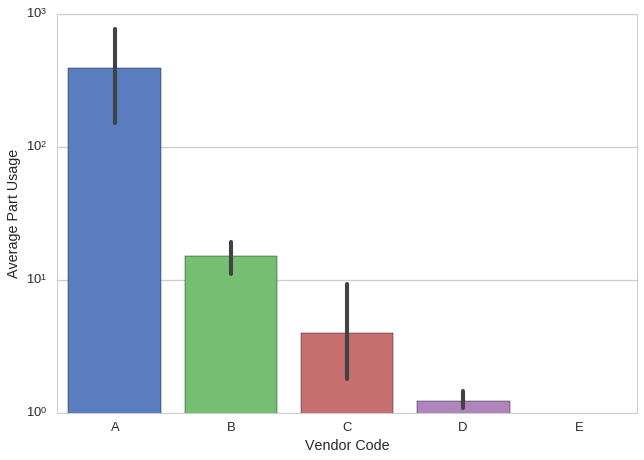

In [14]:
data = atCurrent
g = sns.barplot(x='Vendor Code', y="Total Usage", data=data, order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Average Part Usage')
#g.set_title('Part Purchase Volume By Vendor')

### Average Part Cost by Vendor

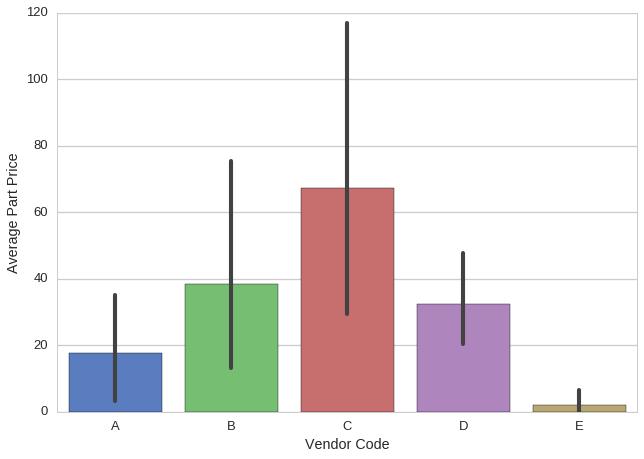

In [7]:
data = atCurrent
g = sns.barplot(x='Vendor Code', y="Unit Cost", data=data, order=['A', 'B', 'C', 'D', 'E'])
#g.set(yscale="log")
g.set_ylabel('Average Part Price')
#g.set_title('Part Price By Vendor')

### Purchase Volume by Vendor

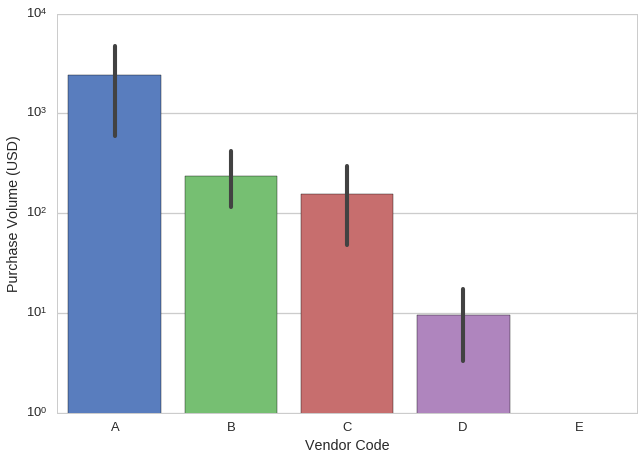

In [8]:
data = atCurrent
g = sns.barplot(x='Vendor Code', y="Purchase Volume", data=data, order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Purchase Volume (USD)')
#g.set_title('Comparison of Mean Purchase Volume From Vendors')

### Implied Fixed Order Cost by Vendor

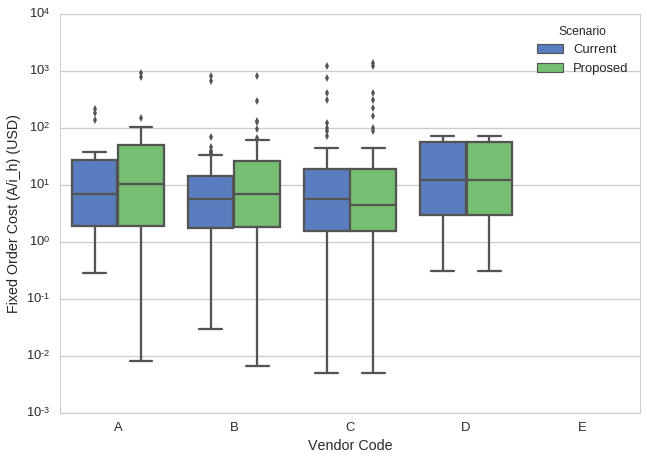

In [16]:
data = atAll.loc[atCurrent['Total Usage'] > 0]
g = sns.boxplot(x='Vendor Code', y="Implied A/i_h", data=data, hue='Scenario', order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Fixed Order Cost (A/i_h) (USD)')
#g.set_title('Comparison of Implied Fixed Order Costs by Vendor')

### Implied Shortage Cost by Vendor

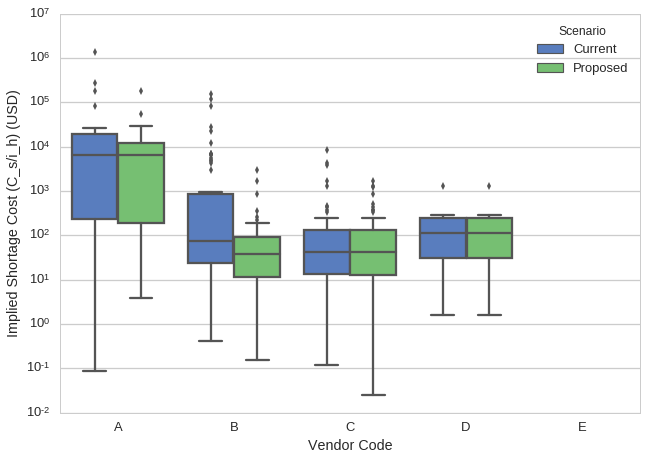

In [15]:
data = atAll.loc[atCurrent['Total Usage'] > 0]
g = sns.boxplot(x='Vendor Code', y="Implied C_s/i_h", data=data, hue='Scenario', order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Implied Shortage Cost (C_s/i_h) (USD)')
#g.set_title('Comparison of Implied Shortage Costs by Vendor')

### Inventory Investment by Vendor

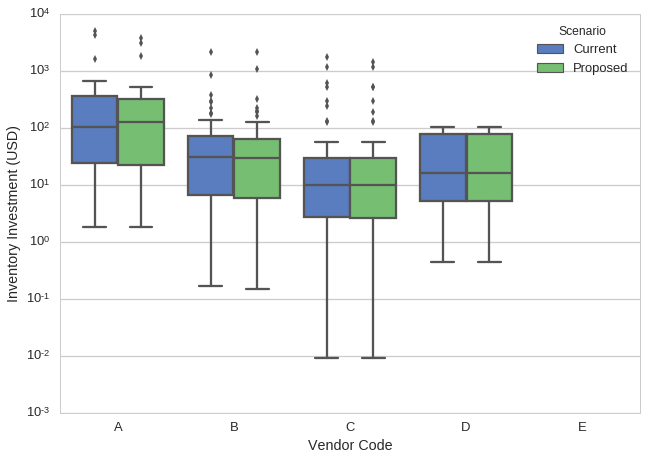

In [9]:
data = atAll.loc[atCurrent['Total Usage'] > 0]
g = sns.boxplot(x='Vendor Code', y="I Investment", data=data, hue='Scenario', order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale='log')
g.set_ylabel('Inventory Investment (USD)')
#g.set_title('Comparison of Inventory Investment by Vendor')

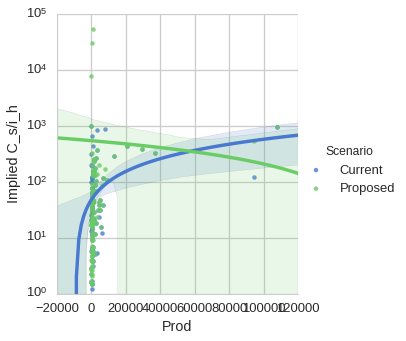

In [186]:
data = atAll.loc[atCurrent['Implied C_s/i_h'] < 1000].copy(deep=True)
data['Prod'] = data['Lead Time (days)']*data['Unit Cost']
g = sns.lmplot(x='Prod', y='Implied C_s/i_h', data=data, hue='Scenario')
g.set(yscale='log')

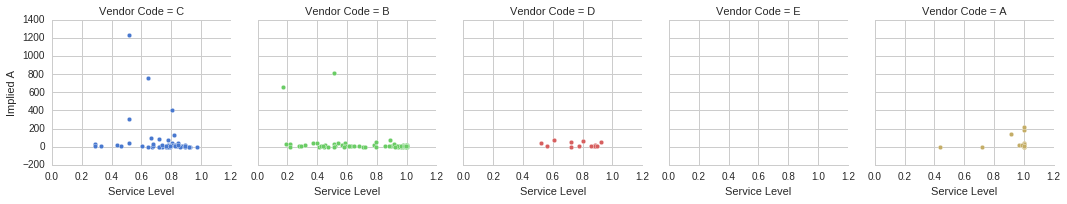

In [35]:
g = sns.FacetGrid(atCurrent, col="Vendor Code",  hue="Vendor Code")
g = (g.map(plt.scatter, "Service Level", "Implied A", edgecolor="w"))

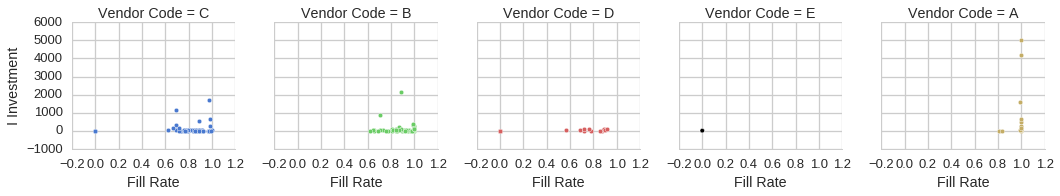

In [22]:
data = atCurrent
g = sns.FacetGrid(data, col="Vendor Code",  hue="Vendor Code")
g = (g.map(plt.scatter, "Fill Rate", 'I Investment', edgecolor="w"))

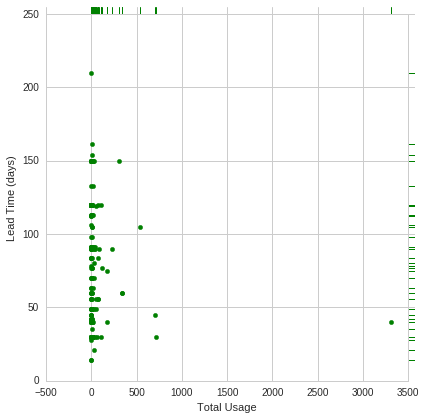

In [11]:
grid = sns.JointGrid(x="Total Usage", y="Lead Time (days)", data=atCurrent, space=0, size=6, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")